### To-do List

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import math
import csv
from glob import glob

"""Change to the data folder"""
train_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in"
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)
            
        return data


# intialize a dataset
train_dataset = ArgoverseDataset(data_path=train_path)
val_dataset  = ArgoverseDataset(data_path=val_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 4

### train_collate definition for train_loader

In [4]:


def train_collate(batch): 
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    #print(batch[0]['car_mask'])
    agent_ids = [scene['agent_id'] for scene in batch]
    #agent_id = batch[0]['agent_id']
    car_masks = [scene['car_mask'] for scene in batch]
    #car_mask = batch[0]['car_mask']
    track_ids = [scene['track_id'] for scene in batch]
    
    #actual_objects = track_id[car_mask.reshape([-1]).astype(int)] #track id actually used
    actual_objects = []
    actual_obj = []
    agent_indices = []
    
    for c_mask,t_id in zip(car_masks,track_ids): #use only tracks that have vehicles on it, if no vehicle present it's labelled as -1
        for mask,track in zip(c_mask,t_id):
            if mask[0] == 1:
                actual_obj.append(track[0][0])
            else:
                actual_obj.append(-1)
        actual_objects.append(actual_obj)
        actual_obj = []
    
    for (i,track),agent_id in zip(enumerate(actual_objects),agent_ids): #will look through the tracks with vehicles and see which one is the agent's track
        for j,tr in enumerate(track):
    
            if tr == agent_id:
                agent_index = j
                break
        agent_indices.append(agent_index)
    
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    scenes_indices = [scene['scene_idx'] for scene in batch]
    return [inp, out,scenes_indices,agent_indices]

### val_collate definition for val_loader

In [5]:
def val_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.LongTensor(inp)
    
    agent_ids = [scene['agent_id'] for scene in batch]
    car_masks = [scene['car_mask'] for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    
    actual_objects = [] #track id actually used
    actual_obj = []
    agent_indices = []
    
    for c_mask,t_id in zip(car_masks,track_ids): #use only tracks that have vehicles on it, if no vehicle present it's labelled as -1
        for mask,track in zip(c_mask,t_id):
            if mask[0] == 1:
                actual_obj.append(track[0][0])
            else:
                actual_obj.append(-1)
        actual_objects.append(actual_obj)
        actual_obj = []
    
    for (i,track),agent_id in zip(enumerate(actual_objects),agent_ids): #will look through the tracks with vehicles and see which one is the agent's track
        for j,tr in enumerate(track):
            if tr == agent_id:
                agent_index = j
                break
        agent_indices.append(agent_index)
    
    inp = torch.LongTensor(inp)

    scenes_indices = [scene['scene_idx'] for scene in batch]
    return [inp, scenes_indices,agent_indices]

### Set train_loader and val_loader

In [6]:
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=train_collate, num_workers=8)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=val_collate, num_workers=8)

### Fully Connected Network Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class FullyConnectedNet(nn.Module):
    """This class defines your deep learning model that extends a Module class
      The constructor of your class defines the layers of the model. 
      The forward() function defines how to forward propagate 
      input through the defined layers of the model.
      Many layers are available, such as Linear for fully connected layers, 
      Conv2d for convolutional layers, and MaxPool2d for pooling layers.

    """
    #============================================
    # TODO: Implement Fully Connected Network model.
    #=============================================
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4,100,3) #it's 4*60 because there's 60 vehicles and we're just looking at it's present features [pos_x,pos_y,vel_x,vel_y]
        self.pool = nn.MaxPool2d(2, 2)
        self.batchNorm1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100,60,1)
        self.fc1 = nn.Linear(60 * 19 * 4, 17500)
        self.batchNorm2 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(17500,17500)
        self.fc3 = nn.Linear(17500, 60 * 30 * 4)
        self.softMax = nn.LogSoftmax()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    '''
        1) Understand dataset correctly (input shape and output shape etc.)
        2) 
    '''
    def forward(self, x):
        #x = x.to(self.device)
        x = x.cuda()
        #x = self.pool(F.relu(self.conv1(x)))#F.relu(self.conv1(x))
        #x = self.batchNorm1(x)
        #print("xshape in forward after batchNorm1: ",x.shape)
        #x = self.pool(F.relu(self.conv2(x)))
        #print("xshape in forward after conv2: ",x.shape)
        
        #x = x.view(-1, 60 * 19 * 4)
        x = F.relu(self.fc1(x))
        #print("xshape in forward after one fc1: ",x.shape)
        #x = self.batchNorm2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.softMax(x) #Need to add this because training and testing use nll_loss
        return x

### define Train function

In [8]:
from tqdm import tqdm_notebook as tqdm
def train(model, device, train_batch, optimizer, epoch,log_interval=10000):
    model.train()
    #iterator = tqdm(train_batch, total=int(len(train_batch)))
    #counter = 0
    
    data,target,scenes_indices,agent_indices = train_batch
    data = data.to(device)
    #target = target.to(device)
    optimizer.zero_grad()
    #print(len(train_batch))
    data = data.type(torch.FloatTensor)
    #print(len(data)
    
    data = torch.reshape(data,(len(data),60 * 19 * 4))
    target = target.type(torch.FloatTensor)
    target = torch.reshape(target,(len(data),60 * 30 * 4)) 
    output = model(data)
    
    outputPickleFormat = torch.reshape(output,(len(data),60,30,4))

    target = target.to(device)
    #output = torch.reshape(output,(1,60 * 30 * 4))
    targetPickleFormat = torch.reshape(target,(len(data),60,30,4))

    
    '''
    #calculate loss with respect to the agent's movements
    agent_batch_out = []
    agent_batch_target = []

    for scene_out,scene_target,agent_idx in zip(outputPickleFormat,targetPickleFormat,agent_indices):
        agent_batch_out.append(scene_out[agent_idx].tolist())
        agent_batch_target.append(scene_target[agent_idx].tolist())

    agent_batch_out = torch.tensor(agent_batch_out,requires_grad=True)
    agent_batch_target = torch.tensor(agent_batch_target,requires_grad=True)

    agent_batch_out = agent_batch_out.to(device)
    agent_batch_target = agent_batch_target.to(device)
    '''
    
    loss = torch.mean((targetPickleFormat-outputPickleFormat)**2)**0.5
    #print(loss)
    loss.backward()

    optimizer.step()
    
    return loss.item()
    #counter += 1
    #torch.cuda.empty_cache()
    #iterator.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
    #histogram for x and y input positions of train's agents
    

### define Test function

In [9]:
def test(model, device, test_batch,epoch):#target_loader,epoch):
    model.eval()
    test_loss = 0
    predictedPos = []
    predPosArr = []
    correct = 0
    
    with torch.no_grad():
        data,scenes_indices,agent_indices = test_batch
        data = data.to(device)
        data = data.type(torch.FloatTensor)
        data = torch.reshape(data,(len(data),60 * 19 * 4))
        output = model(data)
        output = torch.reshape(output,(len(data),60 * 30 * 4))
        outputPickleFormat = torch.reshape(output,(len(data),60,30,4))
       

        #Get target agent's pos x and pos y to put into csv for submission later on
        agent_batch_out = []
        agent_predicted_vals = []
        for scene_out,agent_idx,scene_idx in zip(outputPickleFormat,agent_indices,scenes_indices):
            for time_step in scene_out[agent_idx]:
                agent_predicted_vals.append(time_step[0].item())
                agent_predicted_vals.append(time_step[1].item())
            agent_predicted_vals.insert(0,scene_idx)
            agent_batch_out.append(agent_predicted_vals)
            agent_predicted_vals = []

    return agent_batch_out
    

### Write CSV header

In [10]:
import matplotlib.pyplot as plt
import random

with open('submission.csv','w',newline='') as f:
    thewriter = csv.writer(f)
    headerRow = []
    
    headerRow.append("ID")
    for i in range(1,61):
        headerRow.append("v" + str(i))
        
    thewriter.writerow(headerRow)

### show_sample_batch function definition

In [11]:
agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out,scenes_indices = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

### Definition of histogram plots for input and output for training

In [12]:
def plotTrainInOutPos(inp_posx_arr,inp_posy_arr,out_posx_arr,out_posy_arr,out_vel_arr,out_vel_target_arr,bins_cnt):
    plt.style.use('fivethirtyeight')
    plt.hist(inp_posx_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Input x-axis distribution for all agents in training")
    plt.xlabel("x-position")
    plt.ylabel("frequency")
    plt.show()

    plt.style.use('fivethirtyeight')
    plt.hist(inp_posy_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Input y-axis distribution for all agents in training")
    plt.xlabel("y-position")
    plt.ylabel("frequency")
    plt.show()

    #histogram for x and y output positions of train's agents
    plt.style.use('fivethirtyeight')
    plt.hist(out_posx_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Output x-axis distribution for all agents in training")
    plt.xlabel("x-position")
    plt.ylabel("frequency")
    plt.show()

    plt.style.use('fivethirtyeight')
    plt.hist(out_posy_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Output y-axis distribution for all agents in training")
    plt.xlabel("y-position")
    plt.ylabel("frequency")
    plt.show()
    
    plt.style.use('fivethirtyeight')
    plt.hist(out_vel_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Velocity out magnitudes distribution")
    plt.xlabel("Velocity Magnitudes")
    plt.ylabel("frequency")
    plt.show()
    
    plt.style.use('fivethirtyeight')
    plt.hist(out_vel_target_arr,bins=bins_cnt,edgecolor='black',log='true')
    plt.title("Velocity out magnitudes distribution for target agents")
    plt.xlabel("Velocity Magnitudes")
    plt.ylabel("frequency")
    plt.show()

In [13]:
def plotLoss(loss_arr,epoch):
    plt.style.use('fivethirtyeight')
    plt.plot(loss_arr,'r')
    plt.title("Loss graph after epoch " + str(epoch))
    plt.xlabel("indices")
    plt.ylabel("loss")
    plt.show()

### Start training

cuda chosen
Number of batches to iterate through for training dataset:  51486
Batch size:  4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Done with training on epoch  1


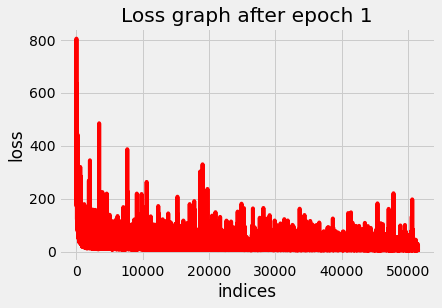

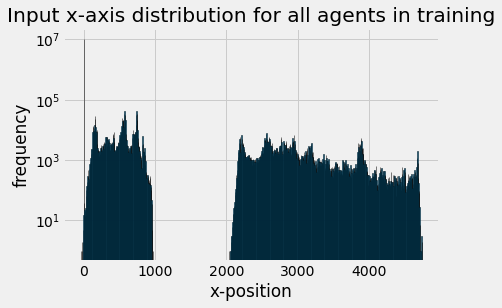

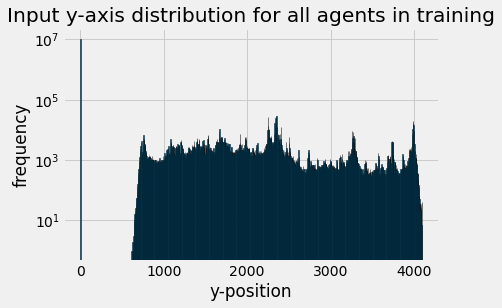

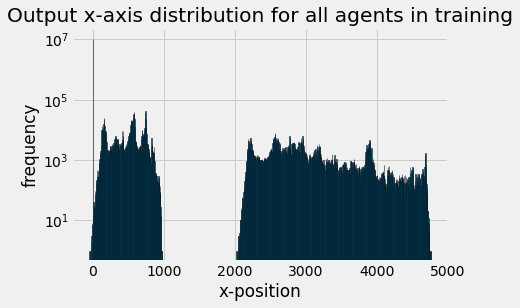

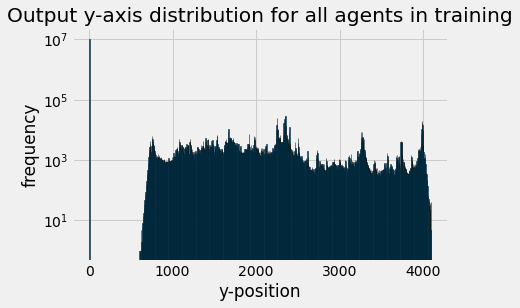

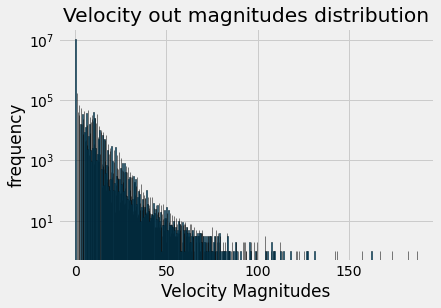

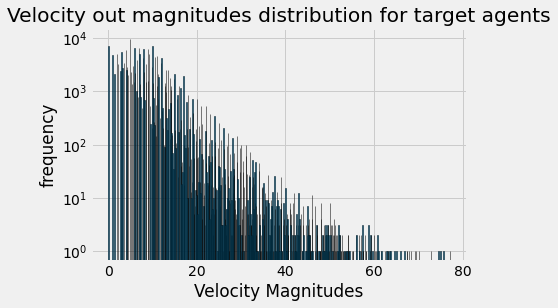

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:128: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Done with epoch  1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
learning_rate = 1e-5

if torch.cuda.is_available():
    print("cuda chosen")
    dev = "cuda"
else:
    print("cpu chosen")
    dev = "cpu"
        
device = dev
model = FullyConnectedNet().cuda() #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epoch = 10


inp_posx_hist = []
inp_posy_hist = []
out_posx_hist = []
out_posy_hist = []
out_vel_hist = []
out_vel_target_hist = []

training_samples_target_posx = []
training_samples_target_posy = []
training_samples_target_velx = []
training_samples_target_vely = []
training_samples_pred_in =  []
training_samples_pred_out_posx = []
training_samples_pred_out_posy = []
training_samples_pred_out_velx = []
training_samples_pred_out_vely = []
loss_arr = []

print("Number of batches to iterate through for training dataset: ",len(train_loader))
print("Batch size: ",batch_sz)
for epoch in range(1, num_epoch + 1):
    iterator_train = tqdm(train_loader, total=int(len(train_loader)))
    
    for i_batch, train_batch in enumerate(iterator_train): #Begin training 
        if epoch == 1:
            inp_train, out_train, scenes_indices_train,agent_indices_train = train_batch
            #print(inp_train.shape)
            for scene_in,scene_out,agent_idx in zip(inp_train,out_train,agent_indices_train):
                for idx,(vehicle_in,vehicle_out) in enumerate(zip(scene_in,scene_out)):
                        inp_posx_hist.append(vehicle_in[18][0].item())
                        inp_posy_hist.append(vehicle_in[18][1].item())
                        out_posx_hist.append(vehicle_out[18][0].item())
                        out_posy_hist.append(vehicle_out[18][1].item())
                        out_vel_hist.append(((vehicle_out[18][2].item())**2 + (vehicle_out[18][3].item())**2)**0.5)
                        if idx == agent_idx:
                            out_vel_target_hist.append(((vehicle_out[18][2].item())**2 + (vehicle_out[18][3].item())**2)**0.5)
        
        if(i_batch < 2) and epoch == 1:
            for scene_in,scene_out in zip(inp_train,out_train):
                scene_out = torch.reshape(scene_out,(1,60,30,4))
                scene_out = scene_out.type(torch.FloatTensor)
                for vehicles in scene_out[0]:
                    for time_step in vehicles:
                        training_samples_target_posx.append(time_step[0].item())
                        training_samples_target_posy.append(time_step[1].item())
                        training_samples_target_velx.append(time_step[2].item())
                        training_samples_target_vely.append(time_step[3].item())

                scene_in = torch.reshape(scene_in,(1,60,19,4))
                training_samples_pred_in.append(scene_in)
                
        add_loss = train(model, device, train_batch, optimizer, epoch) #replace train_loader with our input training data
        loss_arr.append(add_loss)
        #print("add_loss raw: ",add_loss)
        #print("add_loss averaged: ",add_loss / len(train_batch))
    
    

    
    if epoch == 1:
        '''for sample_pred_in in training_samples_pred_in:
            sample_pred_in = torch.reshape(sample_pred_in,(1,60*19*4)) #need to reshape to this for our model
            sample_pred_in = sample_pred_in.type(torch.FloatTensor)
            sample_pred_out = model(sample_pred_in) #will have size 1x (60*30*4)
            sample_pred_out = torch.reshape(sample_pred_out,(1,60,30,4))
            for vehicle in sample_pred_out[0]:
                for time_step in vehicle:
                    training_samples_pred_out_posx.append(time_step[0].item())
                    training_samples_pred_out_posy.append(time_step[1].item())
                    training_samples_pred_out_velx.append(time_step[2].item())
                    training_samples_pred_out_vely.append(time_step[3].item())
        
        t = numpy.linspace(0, len(training_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(t,training_samples_pred_out_posx,t,training_samples_target_posx)
        plt.title("Training Sample comparison x-pos graph")
        plt.xlabel("indices")
        plt.ylabel("Coordinate Val")
        plt.show()

        s = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(s,training_samples_pred_out_posy,s,training_samples_target_posy)
        plt.title("Training Sample comparison y-pos graph")
        plt.xlabel("indices")
        plt.ylabel("Coordinate Val")
        plt.show()

        v = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(v,training_samples_pred_out_velx,v,training_samples_target_velx)
        plt.title("Training Sample comparison x-vel graph")
        plt.xlabel("indices")
        plt.ylabel("Velocity Value")
        plt.show()

        w = numpy.linspace(0, len(train_samples_pred_out_posx), endpoint=True)
        plt.style.use('fivethirtyeight')
        plt.plot(w,training_samples_pred_out_vely,w,training_samples_target_vely)
        plt.title("Training Sample comparison y-vel graph")
        plt.xlabel("indices")
        plt.ylabel("Velocity Value")
        plt.show()'''
    
    print("Done with training on epoch ",epoch)
    plotLoss(loss_arr,epoch)
    
    
    if epoch == 1:
        plotTrainInOutPos(inp_posx_hist,inp_posy_hist,out_posx_hist,out_posy_hist,out_vel_hist,out_vel_target_hist,1000)
    
    #Begin testing
    iterator_test = tqdm(val_loader,total=int(len(val_loader)))
    for i_batch,test_batch in enumerate(iterator_test):
        predicted_batches = test(model, device, test_batch,epoch)
        
        if epoch == num_epoch: #if done with the last epoch then we write to file
            with open('submission.csv','a',newline='') as f: #append to csv
                thewriter = csv.writer(f)
                for p_list in predicted_batches:
                    thewriter.writerow(p_list)
    
    
    print("Done with epoch ",epoch)